In [3]:
import numpy as np
from matplotlib import pyplot
from matplotlib.colors import Normalize
from scipy import stats
from scipy.special import logsumexp
from IPython.display import Markdown
import seaborn as sns
import pandas as pd
import itertools
import functools
import dask.bag as db

First we define some parameters for our system

In [4]:
# mathematica: {{\[Mu]->0.00331511,\[Lambda]->0.005,\[Rho]->1.}}
lamda = 0.005
kappa = 0.25
rho = 0.01
mu = 0.01
mean_s = kappa / lamda
mean_x = mean_s * rho / mu
tau_s = 1/lamda
tau_x = 1/mu * (1 + rho * mu / (lamda * (lamda + rho + mu)))
delta = tau_x/50

Markdown(r"""
We define the following parameters

$\langle s \rangle = {}$

$\langle x \rangle = {}$

$\tau_s = {}$

$\tau_x = {}$

$\rho \Delta = {}$
""".format(mean_s, mean_x, tau_s, tau_x, rho * delta))


We define the following parameters

$\langle s \rangle = 50.0$

$\langle x \rangle = 50.0$

$\tau_s = 200.0$

$\tau_x = 180.0$

$\rho \Delta = 0.036000000000000004$


The analytical rate is defined by $R(S,X)=\frac{\lambda}{2}\left[\sqrt{1+\rho/\lambda}-1\right]$

In [5]:
analytical_rate = lambda rho, lamda: lamda/2 * (np.sqrt(1 + rho/lamda) - 1)
Markdown("$R(S,X) = {}$".format(analytical_rate(rho, lamda)))

$R(S,X) = 0.001830127018922193$

In [6]:
def sigma_ss(rho, mu, lamda, kappa):
    return kappa / lamda

def sigma_xs(rho, mu, lamda, kappa):
    return sigma_ss(rho, mu, lamda, kappa) / (lamda + mu)

def sigma_xx(rho, mu, lamda, kappa):
    return kappa / lamda * rho / mu * (1 + rho / (lamda + mu))

def corr_ss(t, rho, mu, lamda, kappa):
    return kappa / lamda * np.exp(-np.abs(t) * lamda)

def corr_xs_pos(t, rho, mu, lamda, kappa):
    return rho * kappa / lamda / (lamda + mu) * np.exp(-lamda * t)

def corr_sx_pos(t, rho, mu, lamda, kappa):
    a = rho * kappa / lamda / (lamda - mu)
    b1 = (1 + (lamda - mu)/(lamda + mu))*np.exp(-mu * t)
    b2 = - np.exp(-lamda * np.abs(t))
    return a * (b1 + b2)

def corr_xs(t, rho, mu, lamda, kappa):
    return np.where(t >= 0, corr_xs_pos(t, rho, mu, lamda, kappa), corr_sx_pos(-t, rho, mu, lamda, kappa))

def corr_sx(t, rho, mu, lamda, kappa):
    return np.where(t >= 0, corr_sx_pos(t, rho, mu, lamda, kappa), corr_xs_pos(-t, rho, mu, lamda, kappa))

def corr_xx(t, rho, mu, lamda, kappa):
    c1 = np.exp(-mu * np.abs(t)) - np.exp(-lamda * np.abs(t))
    c2 = np.exp(-mu * np.abs(t))
    d1 = rho**2 / (lamda**2 - mu**2) * kappa / lamda
    d2 = (1+rho/(lamda+mu)) * kappa / lamda * rho / mu
    return (d1*c1 + d2*c2)

def corr_z(t, rho, mu, lamda, kappa):
    c_ss = corr_ss(t, rho, mu, lamda, kappa)
    c_sx = corr_sx(t, rho, mu, lamda, kappa)
    c_xs = corr_xs(t, rho, mu, lamda, kappa)
    c_xx = corr_xx(t, rho, mu, lamda, kappa)
    return np.block([[c_ss, c_xs], [c_sx, c_xx]])

def time_matrix(N, delta_t):
    time_stamps = np.expand_dims(np.linspace(0, (N-1)*delta_t, N), 0)
    return time_stamps - time_stamps.T

/home/ipausers/reinhardt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:375: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/home/ipausers/reinhardt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout()


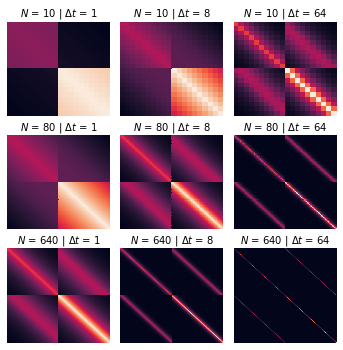

In [14]:
data = []
for n_dim in [10, 80, 640]:
    for dt in [1, 8, 64]:        
        t = time_matrix(n_dim, dt)
        c_z = corr_z(t, rho, mu, lamda, kappa)
        data.append({'n_dim': n_dim, 'dt': dt, 'correlation': c_z})

def draw_heatmap(*args, **kw_args):
    return sns.heatmap(args[0].values[0], **kw_args)
        
data = pd.DataFrame(data)
g = sns.FacetGrid(data, col='dt', row='n_dim', sharex=False, sharey=False, aspect=1, height=5/2.54, gridspec_kws={"wspace": 0.1, "hspace": 0.2})
g = g.map(draw_heatmap, 'correlation', cbar=False, xticklabels=False, yticklabels=False).set_titles("$N$ = {row_name} | $\Delta t$ = {col_name}").set(xlabel=None)
pyplot.savefig('matrix_plots.png', dpi=300)
# pyplot.matshow(c_z / np.sqrt(np.outer(np.diag(c_z), np.diag(c_z))))

In [5]:
c_xx

NameError: name 'c_xx' is not defined

In [7]:
# from https://blogs.sas.com/content/iml/2012/10/31/compute-the-log-determinant-of-a-matrix.html
def logdet_symmetric(matrix):
    lower_triangular = np.linalg.cholesky(matrix)
    return 2 * np.sum(np.log(np.diag(lower_triangular)))

In [8]:
def mutual_information_from_matrix(t, rho, mu, lamda, kappa):
    c_ss = corr_ss(t, rho, mu, lamda, kappa)
    c_xx = corr_xx(t, rho, mu, lamda, kappa)
    z = corr_z(t, rho, mu,  lamda, kappa)
    
    det_c_ss = logdet_symmetric(c_ss)
    det_c_xx = logdet_symmetric(c_xx)    
    det_z = logdet_symmetric(z)
    
    return 0.5 * (det_c_ss + det_c_xx - det_z)

def conditional_entropy_from_matrix(t, rho, mu, lamda, kappa):
    c_ss = corr_ss(t, rho, mu, lamda, kappa)
    z = corr_z(t, rho, mu,  lamda, kappa)
    
    det_c_ss = logdet_symmetric(c_ss)
    n = c_ss.shape[0]
    det_z = logdet_symmetric(z)
        
    return 0.5 * (det_z - det_c_ss + n*np.log(2*np.pi*np.e))

@np.vectorize
def mutual_information(N, delta_t, rho, mu, lamda, kappa):
    t = time_matrix(N, delta_t)
    return mutual_information_from_matrix(t, rho, mu, lamda, kappa)

@np.vectorize
def conditional_entropy(N, delta_t, rho, mu, lamda, kappa):
    t = time_matrix(N, delta_t)
    return conditional_entropy_from_matrix(t, rho, mu, lamda, kappa)

In [255]:
def norm_pdf(s, x, cov):
    inv_cov = np.linalg.inv(cov)
    shape = inv_cov.shape
    
    inv_cov.reshape
    
    np.einsum('->ij')

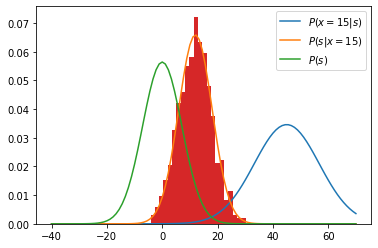

In [7]:
t = time_matrix(1,0.001)

c_ss = corr_ss(t, rho, mu, lamda, kappa)
c_sx = corr_sx(t, rho, mu, lamda, kappa)
c_xs = corr_xs(t, rho, mu, lamda, kappa)
c_xx = corr_xx(t, rho, mu, lamda, kappa)
marg_s = stats.multivariate_normal(cov=c_ss)
reg_coef = c_sx @ np.linalg.inv(c_xx)
cov = c_ss - reg_coef @ c_xs
mc_samples = []

x = np.array([30.0])
mean = np.dot(reg_coef, x)
dist = stats.multivariate_normal(mean=mean, cov=cov)

z = corr_z(t, rho, mu,  lamda, kappa)
points = np.linspace(-40, 70, 100)
points_2d = np.vstack([points, np.broadcast_to(x, points.shape)]).T

p_x_s = stats.multivariate_normal.pdf(x=points_2d, cov=z) / stats.multivariate_normal.pdf(x=points, cov=c_ss)
norm = np.trapz(p_x_s, x=points)

p_s_x = stats.multivariate_normal.pdf(x=points_2d, cov=z) / stats.multivariate_normal.pdf(x=x, cov=c_xx)

pyplot.plot(points, p_x_s / norm, label='$P(x=15|s)$')
pyplot.plot(points, p_s_x, label='$P(s|x=15)$')
pyplot.plot(points, stats.multivariate_normal.pdf(x=points, cov=c_ss), label='$P(s)$')
pyplot.hist(dist.rvs(1000), density=True, bins='auto')
pyplot.legend();

In [9]:
def estimate_p_x(x, num_s, t, renew=True):
    joint = stats.multivariate_normal(cov=corr_z(t, rho, mu, lamda, kappa))
    marg_s = stats.multivariate_normal(cov=corr_ss(t, rho, mu, lamda, kappa))
    
    num_s_components = marg_s.cov.shape[0]
    
    x = np.asarray(x)
    if x.ndim < 2:
        # assume x are samples from 1d rv.
        x = np.expand_dims(x, -1)
    
    s_shape = x.shape[:-1] + (num_s, num_s_components)
    if renew:
        s_samples = marg_s.rvs(x.shape[:-1] + (num_s,)).reshape(s_shape)
    else:
        s_samples = marg_s.rvs((num_s,)).reshape((num_s, num_s_components))
        s_samples = np.broadcast_to(s_samples, s_shape)
    x_grid = np.broadcast_to(np.expand_dims(x, -2), x.shape[:-1] + (num_s, x.shape[-1]))
    
    points = np.concatenate([s_samples, x_grid], axis=-1)
    likelihood = joint.logpdf(points) - marg_s.logpdf(s_samples)
    return x, logsumexp(likelihood, axis=-1) - np.log(likelihood.shape[-1])

def conditional_covariance(t):
    c_ss = corr_ss(t, rho, mu, lamda, kappa)
    c_sx = corr_sx(t, rho, mu, lamda, kappa)
    c_xs = corr_xs(t, rho, mu, lamda, kappa)
    c_xx = corr_xx(t, rho, mu, lamda, kappa)
        
    regression_coef = c_xs @ np.linalg.inv(c_ss)
    return regression_coef, c_xx - regression_coef @ c_sx

def estimate_marginal_entropy(num_x, num_s, t, renew=True, importance=False):
    marg_x = stats.multivariate_normal(cov=corr_xx(t, rho, mu, lamda, kappa))
    if importance:
        # find p(x|s) as a distribution over s for a given x. It turns out to be a gaussian distribution as well.
        c_ss = corr_ss(t, rho, mu, lamda, kappa)
        c_sx = corr_sx(t, rho, mu, lamda, kappa)
        c_xs = corr_xs(t, rho, mu, lamda, kappa)
        c_xx = corr_xx(t, rho, mu, lamda, kappa)
        marg_s = stats.multivariate_normal(cov=c_ss)
#         reg_coef = np.linalg.inv(c_xs) @ c_ss
        reg_coef = c_sx @ np.linalg.inv(c_xx)
#         cov = reg_coef.T @ c_xx @ reg_coef - c_ss
        cov = c_ss - reg_coef @ c_xs
        mc_samples = []
        for x in marg_x.rvs(num_x):
            x = np.atleast_1d(x)
            dist = stats.multivariate_normal(mean=np.dot(reg_coef, x), cov=cov)
            mc_samples.append(marg_x.logpdf(x))
        estimated_p_x = logsumexp(np.asarray(mc_samples), axis=-1) - np.log(num_s)
    else:
        _, estimated_p_x = estimate_p_x(marg_x.rvs(num_x), num_s, t, renew)
        
    return -estimated_p_x.mean(axis=-1)

def estimate_conditional_entropy(num_x, num_s, t):
    c_ss = corr_ss(t, rho, mu, lamda, kappa)
    marg_s = stats.multivariate_normal(cov=c_ss)
    
    regression_coef, conditional_cov = conditional_covariance(t)
    
    signals = marg_s.rvs(num_s)
    
    signal_averages = []
    for s in signals:
        x_given_s = stats.multivariate_normal(mean=np.dot(regression_coef, s), cov=conditional_cov)
        signal_averages.append(x_given_s.logpdf(x_given_s.rvs(num_x)).mean(axis=0))
        
    return -np.mean(signal_averages)

In [10]:
t = time_matrix(10,100)
marg_x = stats.multivariate_normal(cov=corr_xx(t, rho, mu, lamda, kappa))
estimate_marginal_entropy(100, 1000, t, renew=False, importance=False), marg_x.entropy().item()

(34.5580317113199, 34.61826016068696)

In [11]:
conditional_entropy_from_matrix(t, rho, mu, lamda, kappa)

33.358850293162725

In [10]:
del(client)

In [13]:
del(cluster)

In [1]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=12, threads_per_worker=1)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:33344 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 12 Cores: 12 Memory: 137.44 GB


In [28]:
def generate_sample(dim, num_r, num_s, sparsity, umbrella, *args):
    dt = sparsity / dim
    t = time_matrix(dim, dt)
    marg_x = stats.multivariate_normal(cov=corr_xx(t, rho, mu, lamda, kappa))
    estimate = estimate_marginal_entropy(num_r, num_s, t, renew=False, importance=umbrella)
    return {
        "dimensions": dim,
        "marginal entropy": estimate,
        "theory": marg_x.entropy().item(),
        "num signals": num_s,
        "num responses": num_r,
        "umbrella": umbrella,
        "sparsity": sparsity,
        "dt": dt
    }

args = db.from_sequence(list(itertools.product([75, 150, 300], [100], (1/np.linspace(0.002, 0.0032, 12)).astype(int), [4000, 8000, 16000], [False])) * 100, partition_size=10)
dicts = args.starmap(generate_sample).compute()
                        
df = pd.DataFrame(dicts)
df['error'] = df['marginal entropy'] - df['theory']
df['relative error'] = df['error'] / df['theory']
df['absolute error'] = df['error'].abs()
df['inverse responses'] = 1/df['num responses']
df['inverse signals'] = 1/df['num signals']
df['log signals'] = -np.log(df['num signals'])
df

,dimensions,marginal entropy,theory,num signals,num responses,umbrella,sparsity,dt,error,relative error,absolute error,inverse responses,inverse signals,log signals
0,75,243.956429,244.096772,500,100,False,4000,53.333333,-0.140342,-0.000575,0.140342,0.01,0.002000,-6.214608
1,75,262.323390,259.618155,500,100,False,8000,106.666667,2.705235,0.010420,2.705235,0.01,0.002000,-6.214608
2,75,272.506774,268.808782,500,100,False,16000,213.333333,3.697992,0.013757,3.697992,0.01,0.002000,-6.214608
3,75,245.245090,244.096772,474,100,False,4000,53.333333,1.148319,0.004704,1.148319,0.01,0.002110,-6.161207
4,75,262.876205,259.618155,474,100,False,8000,106.666667,3.258050,0.012549,3.258050,0.01,0.002110,-6.161207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10795,300,899.407589,894.357795,323,100,False,8000,26.666667,5.049794,0.005646,5.049794,0.01,0.003096,-5.777652
10796,300,990.254671,975.244128,323,100,False,16000,53.333333,15.010544,0.015392,15.010544,0.01,0.003096,-5.777652
10797,300,803.830827,802.720217,312,100,False,4000,13.333333,1.110610,0.001384,1.110610,0.01,0.003205,-5.743003
10798,300,899.615537,894.357795,312,100,False,8000,26.666667,5.257742,0.005879,5.257742,0.01,0.003205,-5.743003


In [422]:
def hprediction(values, **kw_args):
    return pyplot.axhline(y=values.mean(), **kw_args)

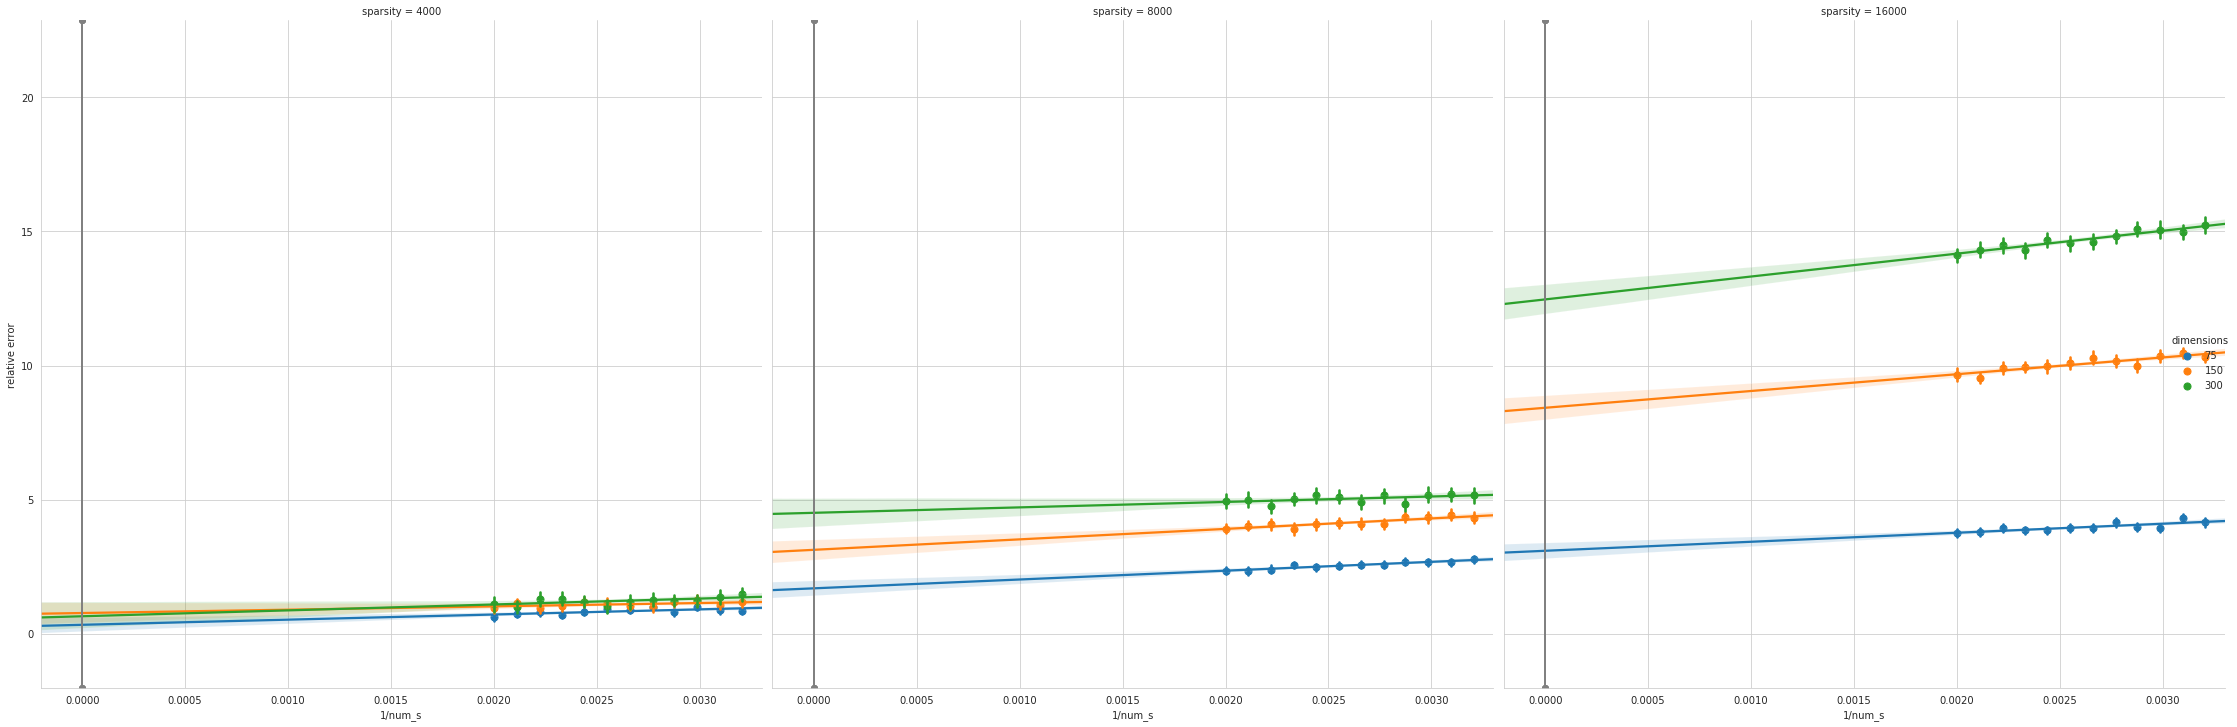

In [35]:
# palette = sns.color_palette('muted', 4)
df['relative absolute error'] = df['relative error'].abs()
with sns.axes_style('whitegrid'):
    grid = sns.lmplot(x='inverse signals', y='error', height=10, hue='dimensions', col='sparsity', truncate=False, x_estimator=np.mean, data=df)
    grid.data = df
    grid.set(xlim=(-0.0002, 0.0033))
#     grid.map(hprediction, 'theory', linestyle='--', label='theoretical prediction', color=palette[3])
    grid.map(pyplot.axvline, x=0, color='grey')
    grid.set_axis_labels('1/num_s', 'relative error')
    pyplot.savefig('plot.pdf')

# Conditional Entropy

In [468]:
dicts = []
for _ in range(30):
    for dt in [100.0]:
        for num_s in [100]:
            for num_r in [1, 10, 100]:
                for dim in [75, 150, 300]:
                    t = time_matrix(dim, dt)
                    theory = conditional_entropy_from_matrix(t, rho, mu, lamda, kappa)
                    estimate = estimate_conditional_entropy(num_r, num_s, t)
                    dicts.append({
                        "dimensions": dim,
                        "conditional entropy": estimate,
                        "theory": theory,
                        "num signals": num_s,
                        "num responses": num_r,
                        "umbrella": umbrella,
                        "dt": dt
                    })
df = pd.DataFrame(dicts)
df['error'] = df['conditional entropy'] - df['theory']
df['relative error'] = df['error'] / df['theory']
df['absolute error'] = df['error'].abs()
df['inverse responses'] = 1/df['num responses']
df['inverse signals'] = 1/df['num signals']
df

,dimensions,conditional entropy,theory,num signals,num responses,umbrella,dt,error,relative error,absolute error,inverse responses,inverse signals
0,75,249.156493,249.184597,500,100,True,100.0,-0.028104,-0.000113,0.028104,0.01,0.002000
1,150,498.207339,498.214304,500,100,True,100.0,-0.006966,-0.000014,0.006966,0.01,0.002000
2,300,996.280268,996.273720,500,100,True,100.0,0.006549,0.000007,0.006549,0.01,0.002000
3,75,249.155135,249.184597,466,100,True,100.0,-0.029462,-0.000118,0.029462,0.01,0.002146
4,150,498.235192,498.214304,466,100,True,100.0,0.020887,0.000042,0.020887,0.01,0.002146
...,...,...,...,...,...,...,...,...,...,...,...,...
715,150,498.253683,498.214304,350,100,True,100.0,0.039379,0.000079,0.039379,0.01,0.002857
716,300,996.219795,996.273720,350,100,True,100.0,-0.053925,-0.000054,0.053925,0.01,0.002857
717,75,249.140143,249.184597,333,100,True,100.0,-0.044454,-0.000178,0.044454,0.01,0.003003
718,150,498.116780,498.214304,333,100,True,100.0,-0.097525,-0.000196,0.097525,0.01,0.003003


In [30]:
df['relative error'].describe()

count    10800.000000
mean         0.008949
std          0.006354
min         -0.004567
25%          0.003588
50%          0.007837
75%          0.014363
max          0.026661
Name: relative error, dtype: float64

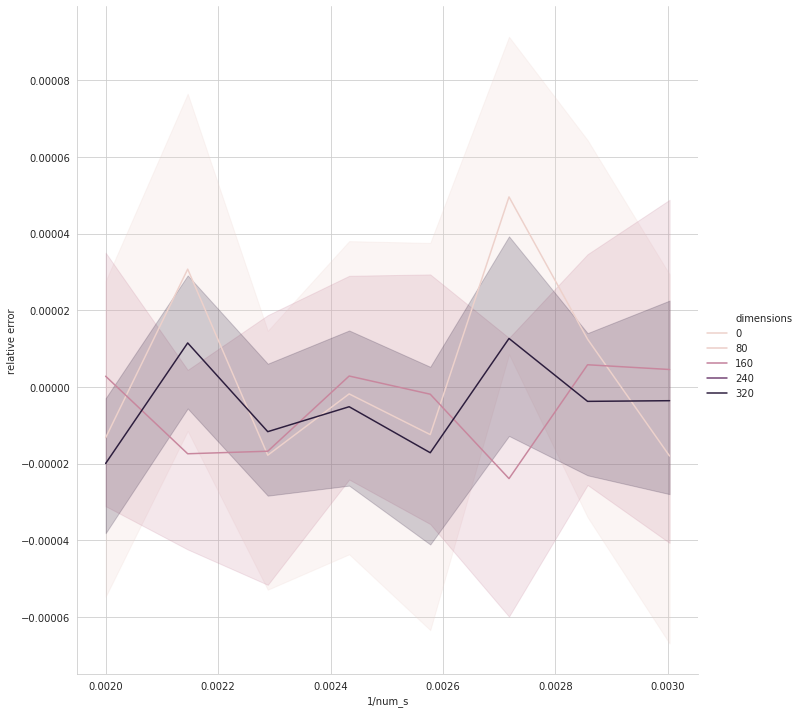

In [481]:
with sns.axes_style('whitegrid'):
    grid = sns.relplot(x='inverse signals', y='relative error', height=10, hue='dimensions', kind='line', data=df)
    grid.set_axis_labels('1/num_s', 'relative error')
    pyplot.savefig('plot.pdf')

In [17]:
joint = stats.multivariate_normal(cov=corr_z(t, rho, mu, lamda, kappa))

In [18]:
joint.rvs(10)

array([[  7.90185396,   7.23547514,  11.02354113,  10.47974677],
       [  1.84833606,   0.8248657 ,  -7.10264369,  -6.93728507],
       [ -1.84398922,  -1.98901298,  -3.38555543,  -4.20613447],
       [  0.21441934,   0.45987805,  -2.38936723,  -2.39712238],
       [ -6.27695   ,  -6.77578296,  -0.91321663,  -1.07902336],
       [  0.13993233,   0.18637735,  18.54536019,  19.08699307],
       [  3.82637264,   4.35001013,  12.32168709,  12.20293984],
       [-10.02912501,  -9.87983134,  -5.79868438,  -5.76591147],
       [  8.0140864 ,   7.15880639, -16.64680577, -17.40042054],
       [  7.69553251,   8.01737119,  13.06005017,  14.57729565]])